In [4]:
import os
import numpy as np
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et
import rasterio
from rasterio.enums import Resampling
import matplotlib.pylab as plt

In [293]:

def get_upscale_tranform(veg_path, upscale_factor = 1):
    """
    Resample geotiff 
    """
    with rasterio.open(veg_path) as dataset:
        veg_data_mask = dataset.dataset_mask()
        veg_data = dataset.read()    

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
#         transform = (30.0, 0.0, 270813.4245952314,
#                            0.0, -30.0, 4178928.1336077712)

        veg_data_mask = dataset.dataset_mask()
        veg_data = dataset.read()
    return transform, veg_data


def upscale_tiff(input_path, upscale_factor):
    transform, input_data = get_upscale_tranform(input_path,upscale_factor)
    
    upscaled_path = '.'.join([input_path.split(".")[0] + '_upscale',
                               
                               input_path.split(".")[1]])
    with rio.open(input_path) as src:

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'width': src.width*upscale_factor,
            'height': src.height*upscale_factor
        })

        with rio.open(upscaled_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform= transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest)
    
    
    return upscaled_path

In [294]:
def open_rio(path):
    data2 = rio.open(path)

    data = data2.read().squeeze()
    data = np.array(data, dtype = float)
#     data[data < -1.] = np.nan
    return data

In [295]:
!ls ../fire_data/VegClassifications

Veg05_05m_icb_5b.tfw                veg69_05m_icb_5.tif.ovr
Veg05_05m_icb_5b.tif                veg69_05m_icb_5_project.tif
Veg05_05m_icb_5b.tif.aux.xml        veg69_05m_icb_5_project_upscale.tif
Veg05_05m_icb_5b.tif.ovr            veg69_05m_icb_5_upscale.tif
Veg05_05m_icb_5b.tif.ovr.aux.xml    veg80_05m_icb_5.tfw
Veg05_05m_icb_5b.tif.vat.cpg        veg80_05m_icb_5.tif
Veg05_05m_icb_5b.tif.vat.dbf        veg80_05m_icb_5.tif.aux.xml
veg12_05m_icb.tfw                   veg80_05m_icb_5.tif.ovr
veg12_05m_icb.tif                   veg80_05m_icb_5.tif.vat.cpg
veg12_05m_icb.tif.aux.xml           veg80_05m_icb_5.tif.vat.dbf
veg12_05m_icb.tif.ovr               veg97_05m_icb_5.tfw
veg12_05m_icb.tif.vat.cpg           veg97_05m_icb_5.tif
veg12_05m_icb.tif.vat.dbf           veg97_05m_icb_5.tif.aux.xml
veg12_05m_icb_upscale.tif           veg97_05m_icb_5.tif.ovr
veg69_05m_icb_5.tfw                 veg97_05m_icb_5.tif.vat.cpg
veg69_05m_icb_5.tif                 veg97_05m_icb_5.tif.vat.dbf
veg69_05m_ic

In [296]:
ls ../fire_data/RF_soil

vwc_1969_rfor30m.tfw*         vwc_2012_rfor30m.tfw*
vwc_1969_rfor30m.tif*         vwc_2012_rfor30m.tif*
vwc_1969_rfor30m.tif.aux.xml* vwc_2012_rfor30m.tif.aux.xml*
vwc_1969_rfor30m.tif.ovr*     vwc_2012_rfor30m.tif.ovr*


In [297]:
# Get data and set working directory
project_dir = "/Users/octavia/Dropbox/fire/"
veg_dir = os.path.join(project_dir, "fire_data/VegClassifications")
# veg_path = os.path.join(veg_dir, "veg69_05m_icb_5.tif")
veg_path = os.path.join(veg_dir, "veg12_05m_icb.tif")
veg_data = rio.open(veg_path)
veg_data.meta
veg_data.bounds

BoundingBox(left=269366.3211650733, bottom=4163244.3001163187, right=290671.3211650733, top=4181184.3001163187)

In [298]:
upscaled_path = upscale_tiff(veg_path, 1./6)
veg = rio.open(upscaled_path)
veg_data = open_rio(upscaled_path)
veg.meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': -2147483648.0,
 'width': 710,
 'height': 598,
 'count': 1,
 'crs': CRS.from_epsg(26911),
 'transform': Affine(30.007042253521128, 0.0, 269366.3211650733,
        0.0, -30.0, 4181184.3001163187)}

In [299]:
# veg = rio.open(veg_path)
# veg_data = open_rio(veg_path)

In [300]:
x_veg = np.arange(veg.bounds.left, veg.bounds.right,30)
y_veg = np.arange(veg.bounds.bottom, veg.bounds.top,30)


In [301]:
soil_dir = os.path.join(project_dir, "fire_data/RF_soil_regrid")

soil_path = os.path.join(soil_dir, "vwcJun12utm11.tif")
# soil_path = os.path.join(project_dir, "fire_data/RF_soil", "vwc_1969_rfor30m.tif")
soil_data = open_rio(soil_path)

x_soil = np.arange(soil.bounds.left, soil.bounds.right,30)
y_soil = np.arange(soil.bounds.bottom, soil.bounds.top,30)

In [302]:
soil = rio.open(soil_path)
soil.transform

Affine(30.0, 0.0, 270813.4245952314,
       0.0, -30.0, 4178928.1336077712)

In [303]:
soil_nan = soil_data.copy()
soil_nan[soil_nan < 0] = np.nan

f = interpolate.interp2d(x_soil, y_soil, soil_data, kind = "linear")
new_soil = f(x_veg,y_veg)

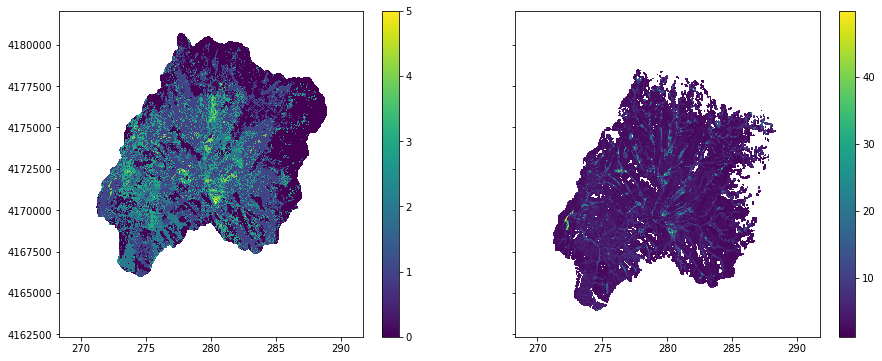

In [304]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharey = True, sharex = True)
veg_nan = veg_data.copy()
veg_nan[veg_nan < 0] = np.nan
c = axes[0].pcolormesh(x_veg/1000, y_veg, veg_nan)
plt.colorbar(c, ax = axes[0])


c = axes[1].pcolormesh(x_soil/1000, y_soil, soil_nan)
plt.colorbar(c, ax = axes[1])
# c = axes[2].pcolormesh(x_veg, y_veg, new_soil)


In [305]:
from scipy import interpolate
# x = np.arange(-5.01, 5.01, 0.25)
# y = np.arange(-5.01, 5.01, 0.25)
# xx, yy = np.meshgrid(x, y)
# z = np.sin(xx**2+yy**2)

f = interpolate.interp2d(x_soil, y_soil, soil_data, kind = "linear")

new_soil = f(x_veg,y_veg)


# new_veg = f(x_soil,y_soil)
new_soil[new_soil< 0]= np.nan

	0 - Rock and water
	1 - Conifer-dominated
	2 - Shrub-dominated
	3 - Sparse meadow
	4 - Dense meadow
	5 - Aspen

[Text(0, 0, 'Rock'),
 Text(0, 0, 'Conifer'),
 Text(0, 0, 'Shrub'),
 Text(0, 0, 'grassland'),
 Text(0, 0, 'wetland'),
 Text(0, 0, 'aspen')]

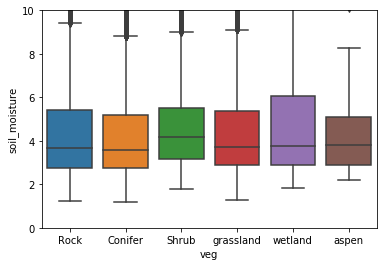

In [146]:
# plt.hist(df[df.veg == 1].soil_moisture, 20, label = 'shrub', normed = 1)
# plt.hist(df[df.veg == 2].soil_moisture, 20, label = "conifer", normed=1)

In [148]:
df[df.veg == 1].mean()


soil_moisture     4.835994
veg               1.000000
theta            12.089985
dtype: float64

In [149]:
df[df.veg == 2].mean()

soil_moisture     5.093259
veg               2.000000
theta            12.733147
dtype: float64

In [93]:
np.nanmax(new_soil)

47.66369843434116

In [98]:
np.nansum(np.isnan(soil_nan) == 0), np.nansum(np.isnan(veg_nan) == 0)

(130722, 175140)

In [97]:
np.nansum(np.isnan(new_soil) == 0)

111523

In [403]:
df = pd.read_csv('/Users/octavia/Dropbox/fire/fire_data/RF_soil_regrid/vwcJun12utm11.csv', sep = " ", header = None)
df.columns = ["x", "y", "z"]
# df = df[df.z >= 0]

In [404]:
df2 = pd.read_csv("/Users/octavia/Dropbox/fire/fire_data/Veg_regrid/veg12_30m_icb.csv", 
                  sep = " ", header = None)
df2.columns = ["x", "y", "z"]
# df2 = df2[df2.z >= 0]

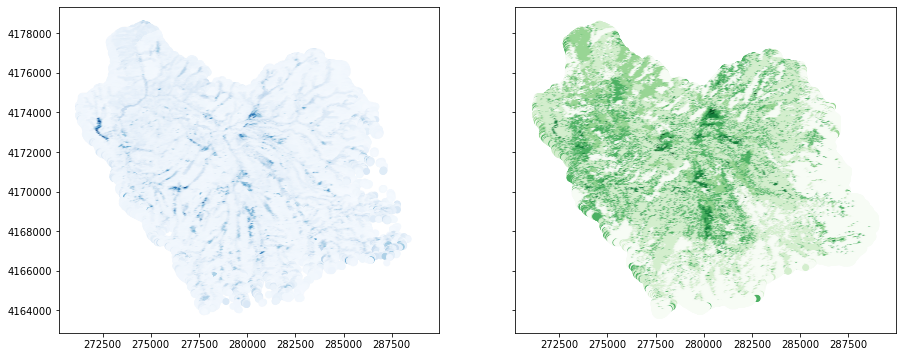

In [358]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharey = True, sharex = True)

axes[0].scatter(df.x, df.y,c = df.z, cmap = "Blues")
axes[1].scatter(df2.x, df2.y, c = df2.z, cmap = "Greens")

In [435]:
x = np.arange(max(df.x.min(), df2.x.min()), min(df.x.max(), df2.x.max()), 30)
y = np.arange(max(df.y.min(), df2.y.min()), min(df.y.max(), df2.y.max()), 30)
grid_x, grid_y = np.meshgrid(x,y)

In [416]:
soil_points = np.array((list(df.x.ravel()), list(df.y.ravel()))).T
soil_values = np.array(df.z)

In [417]:
veg_points = np.array((list(df2.x.ravel()), list(df2.y.ravel()))).T
veg_values = np.array(df2.z)

In [410]:
len

<function len(obj, /)>

In [425]:
from scipy.interpolate import griddata
grid_soil = griddata(soil_points, soil_values, (grid_x, grid_y), method='nearest')
grid_veg = griddata(veg_points, veg_values, (grid_x, grid_y), method='nearest')
# grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
# grid_z2 = g

In [427]:
grid_veg = grid_veg.astype("float")

In [428]:
grid_veg[grid_veg < 0] = np.nan
grid_soil[grid_soil < 0] = np.nan

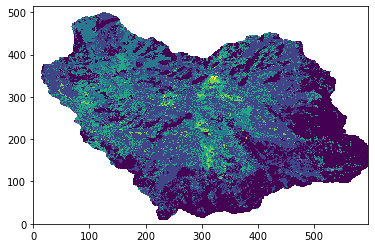

In [430]:

plt.pcolormesh(grid_veg)

/Users/octavia/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


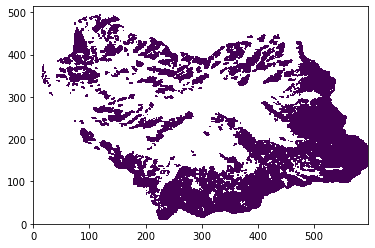

In [440]:
dum = grid_veg.copy()
dum[dum > 0] = np.nan
plt.pcolormesh(dum)

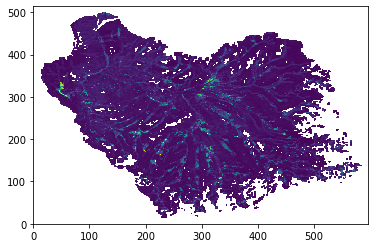

In [432]:
plt.pcolormesh(grid_soil)

[Text(0, 0, 'Rock'),
 Text(0, 0, 'Conifer'),
 Text(0, 0, 'Shrub'),
 Text(0, 0, 'grassland'),
 Text(0, 0, 'wetland'),
 Text(0, 0, 'aspen')]

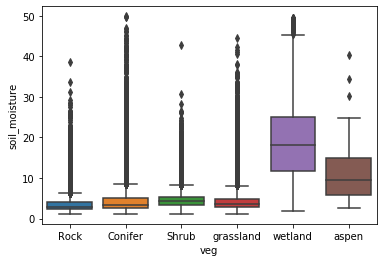

In [438]:
zipped = np.array(( 
        list(grid_x.ravel()), 
        list(grid_y.ravel()),
        list(grid_veg.ravel()), 
        list(grid_soil.ravel())))
inds = np.where((np.isnan(zipped[0] ) ==0) & (np.isnan(zipped[1] ) ==0))
soil_points = zipped[0, inds]
veg_points = zipped[1, inds]


import seaborn as sns

df = pd.DataFrame(zipped.T[inds], columns=["x", "y", "veg", "soil_moisture"])
df["theta"] = df["soil_moisture"]/0.4


ax = sns.boxplot(x="veg", y="soil_moisture", data=df)
# ax.set_ylim(0, 10)
xlabels = ["Rock", "Conifer", "Shrub", "grassland", "wetland", "aspen"]

ax.set_xticklabels(xlabels )

In [449]:
df[df.veg == 1]["soil_moisture"].mean()

4.5610961945065025